# Summary
This notebook develops a Logistic Regression classification model based on processed NBI data. The final model predicts whether a bridge falls into one of two classes after a fixed time period. Specific features that influence prediction are extracted from the model. 
- Classes:
    - Not Poor (Sufficiency Rating >= 50%)
    - Poor (Sufficiency Rating < 50%)

# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## sklearn

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import metrics
# model
from sklearn.linear_model import LogisticRegression
# tuning
from sklearn.model_selection import GridSearchCV
# model save
from sklearn.externals import joblib

# Plot Settings

In [19]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

# Custom Functions

## Rating Conversion
Function to convert numerical ratings to classes

In [20]:
def rat_conv(rating):
    if rating < 50:
        return('poor')
    else:
        return ('not poor')

## Feature Weight Sorting

In [21]:
class FeatureSort():
    '''
    Sort (in descending order) feature weights for Linear Regression or Logistic Regression models
    
    Parameters
    ----------
    weights : array of feature weights from model
    labels : list of feature labels
    '''
    
    def __init__(self, weights, labels):
        
        self.weights = weights
        self.labels = labels
    
    
    def sort_wgts(self, num_ret='all', ret_0=False):
        '''
        Sort feature weights (greatest to least)
        
        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # sort feature weight dataframe
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
        
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)

    
    
    def sort_abs(self, num_ret='all', ret_0=False):
        '''
        Sort feature weights (greatest to least) based on absolute values

        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # create column identifying positive weights
        self.df['positive'] = self.df['feat_wgt'] > 0
        # transform weights to absolute value
        self.df['feat_wgt'] = self.df['feat_wgt'].apply(abs)
        # sort feature weight dataframe
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
            
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)
    
    
    def sort_pct(self, num_ret='all', ret_0=False, rnd=1):
        '''
        Sort feature weights (greatest to least) and return as percentage values
        
        Parameters
        ----------
        num_ret : number of top features to return
        ret_0 : return weights with value of zero
        rnd : decimal precision for rounding
        '''
        
        # create feature weight dataframe
        self.df = pd.DataFrame(self.weights, index=self.labels, columns=['feat_wgt']).copy()
        
        # create column identifying positive weights
        self.df['positive'] = self.df['feat_wgt'] > 0
        # transform weights to absolute value
        self.df['feat_wgt'] = self.df['feat_wgt'].apply(abs)
        # sort weights
        self.df.sort_values(by='feat_wgt', ascending=False, inplace=True)
        # transform weights to percentages
        self.df['feat_wgt'] = round(self.df['feat_wgt'] / self.df['feat_wgt'].sum() * 100, rnd)
        # rename column
        col_rename = self.df.columns.values
        col_rename[0] = 'feat_%'
        self.df.columns = col_rename
        
        # 0 values
        if ret_0 == False:
            # drop weights == 0
            self.df = self.df[self.df.iloc[:, 0] != 0]
            
        # top number of features to return
        if num_ret != 'all':
            # slice number of rows in dataframe
            self.df = self.df.iloc[:num_ret, :]

        # return dataframe
        return(self.df)  

## Plot Feature Affects

In [22]:
def feat_plot(df_feats, feat_lab='df_idx'):
    '''
    Return plot of positive and negative feature affects for bridge performance
    
    Parameters
    ----------
    df_feats : dataframe of a model's feature affect values and if positive
    feat_lab : labels for feature affects, default is dataframe index
    '''
    
    # define feature labels
    if feat_lab == 'df_idx':
        feat_lab = df_feats.index
    
    # initialize plot
    ax = plt.gca()
    # plot feature affects with positive and negative differentiation
    df_feats.iloc[:, 0].plot(kind='bar', ax=ax, color=df_feats.iloc[:, 1]
                            .map({True: 'r', False: 'g'}))
    ax.set_title('Affect on Bridge Performance')
    ax.set_xlabel('NBI Item')
    ax.set_ylabel('Affect (%)')
    # set x-tick labels to feature labels
    ax.set_xticklabels(feat_lab)
    
    # positive label for legend
    pos_patch = mpatches.Patch(color='green', label='Positive')
    # negative label for legend
    neg_patch = mpatches.Patch(color='red', label='Negative')
    # display legend
    legend = plt.legend(title='Correlation', handles=[pos_patch, neg_patch])
    legend.get_title().set_fontsize('18')

# Data
Load dataframes from data processing

In [23]:
df_id = pd.read_csv('data/bridges_id.csv', index_col=0)
df_id.head()

,COUNTY_CODE_003,FEATURES_DESC_006A,FACILITY_CARRIED_007,LOCATION_009
51-1VA3701,810.0,'Lake Smith Outlet ','Amphibious Drive ','0.KM NE of SR-166 '
51-1VA591A,810.0,'Canal ','Golf Course Maint ','Near 18th Hole '
51-2VA00AA,179.0,'Aquia Creek ','MCB-3 ','1.0KM SE of Camp Barrett '
51-2VA00CC,179.0,'Beaver Dam Run Spillway ','MCB-4 ','1.0KM North of MCB-3 '
51-2VA00DD,153.0,'Lucky Run ','MCB-8 ','10M West of MCB-1 '


In [24]:
df_num = pd.read_csv('data/bridges_num.csv', index_col=0)
df_num.head()

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,RIGHT_CURB_MT_050B,ROADWAY_WIDTH_MT_051,DECK_WIDTH_MT_052,VERT_CLR_OVER_MT_053,VERT_CLR_UND_054B,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,RECON_AGE,PERCENT_ADT_TRUCK_109,SUFFICIENCY_RATING_feat_yr
51-1VA3701,99.99,2.0,53.0,2.0,0,2000.0,7.9,45.0,0.0,0.0,...,0.0,8.2,8.8,99.99,0.0,0.0,0.0,53.0,5.0,72.7
51-1VA591A,99.99,4.0,42.0,2.0,0,50.0,6.5,0.0,0.0,0.0,...,0.0,6.5,6.7,99.99,0.0,0.0,0.0,42.0,0.0,53.0
51-2VA00AA,99.99,22.0,60.0,2.0,0,2000.0,6.1,0.0,0.0,0.0,...,0.0,7.5,8.5,99.99,0.0,0.0,0.0,14.0,10.0,69.2
51-2VA00CC,99.99,6.0,60.0,2.0,0,1000.0,7.3,0.0,0.0,0.0,...,0.6,7.3,8.5,99.99,0.0,0.0,0.0,13.0,10.0,73.7
51-2VA00DD,99.99,12.0,60.0,2.0,0,500.0,6.1,0.0,0.0,0.0,...,0.0,7.5,8.5,99.99,0.0,0.0,0.0,13.0,10.0,79.1


In [25]:
df_cat = pd.read_csv('data/bridges_cat.csv', index_col=0)
df_cat.head()

,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,DESIGN_LOAD_031,MEDIAN_CODE_033,STRUCTURE_FLARED_035,RAILINGS_036A,TRANSITIONS_036B,APPR_RAIL_036C,APPR_RAIL_END_036D,...,STRUCTURE_TYPE_043B,APPR_KIND_044A,APPR_TYPE_044B,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060
51-1VA3701,3.0,73.0,19.0,5.0,0.0,0.0,0,0,0,0,...,2,0.0,0.0,3,0,0,0,5,5,5
51-1VA591A,3.0,73.0,19.0,0.0,0.0,0.0,0,0,0,0,...,9,0.0,0.0,1,0,0,0,5,5,6
51-2VA00AA,3.0,73.0,9.0,6.0,0.0,0.0,1,1,1,1,...,5,0.0,0.0,2,3,0,0,5,7,5
51-2VA00CC,3.0,73.0,9.0,0.0,0.0,0.0,0,0,0,0,...,1,0.0,0.0,1,6,0,0,5,6,6
51-2VA00DD,3.0,73.0,9.0,6.0,0.0,0.0,1,1,1,1,...,1,0.0,0.0,2,6,0,0,7,6,5


In [26]:
tar = pd.read_csv('data/bridges_tar.csv', index_col=0, header=None, names=['suff_rating'])
tar.head()

,suff_rating
51-1VA3701,72.7
51-1VA591A,52.3
51-2VA00AA,69.2
51-2VA00CC,63.6
51-2VA00DD,79.1


In [27]:
# number of observations
len(tar)

1639

# Pre-processing

## Categorical Data

In [28]:
# one-hot encode categorical data as strings
cat_enc = pd.get_dummies(df_cat.astype(str))
cat_enc.head()

,TOLL_020_1.0,TOLL_020_2.0,TOLL_020_3.0,MAINTENANCE_021_1.0,MAINTENANCE_021_2.0,MAINTENANCE_021_26.0,MAINTENANCE_021_27.0,MAINTENANCE_021_3.0,MAINTENANCE_021_31.0,MAINTENANCE_021_32.0,...,SUPERSTRUCTURE_COND_059_6,SUPERSTRUCTURE_COND_059_7,SUPERSTRUCTURE_COND_059_8,SUPERSTRUCTURE_COND_059_9,SUPERSTRUCTURE_COND_059_N,SUBSTRUCTURE_COND_060_4,SUBSTRUCTURE_COND_060_5,SUBSTRUCTURE_COND_060_6,SUBSTRUCTURE_COND_060_7,SUBSTRUCTURE_COND_060_8
51-1VA3701,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
51-1VA591A,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
51-2VA00AA,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
51-2VA00CC,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
51-2VA00DD,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Combine Categorical and Numeric Data

In [29]:
# combine numeric and encoded categorical features on index
X = df_num.join(cat_enc)
X.to_csv('data/feat_df.csv')
X.head()

,MIN_VERT_CLR_010,DETOUR_KILOS_019,AGE,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,APPR_WIDTH_MT_032,DEGREES_SKEW_034,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,...,SUPERSTRUCTURE_COND_059_6,SUPERSTRUCTURE_COND_059_7,SUPERSTRUCTURE_COND_059_8,SUPERSTRUCTURE_COND_059_9,SUPERSTRUCTURE_COND_059_N,SUBSTRUCTURE_COND_060_4,SUBSTRUCTURE_COND_060_5,SUBSTRUCTURE_COND_060_6,SUBSTRUCTURE_COND_060_7,SUBSTRUCTURE_COND_060_8
51-1VA3701,99.99,2.0,53.0,2.0,0,2000.0,7.9,45.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
51-1VA591A,99.99,4.0,42.0,2.0,0,50.0,6.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
51-2VA00AA,99.99,22.0,60.0,2.0,0,2000.0,6.1,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,0
51-2VA00CC,99.99,6.0,60.0,2.0,0,1000.0,7.3,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
51-2VA00DD,99.99,12.0,60.0,2.0,0,500.0,6.1,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


## Target Data

In [30]:
# set target column values to categories
y = tar['suff_rating'].apply(rat_conv)

In [31]:
# number in each class
y.value_counts()

not poor    1266
poor         373
Name: suff_rating, dtype: int64

In [32]:
# ratio of classes
y.value_counts()[0] / (y.value_counts()[0] + y.value_counts()[1])

0.7724222086638194

## Train/Test Split
Split data into one group for training the model and another for model evaluation (testing)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Initial Model
Logistic Regression model with balanced weights to account for class imbalance

In [ ]:
# logistic regression model pipeline
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

# fit model to training data
log_pipe.fit(X_train, y_train)
# predict class based on test feature input
log_pred = log_pipe.predict(X_test)

In [ ]:
# output classes
log_pipe.classes_

In [ ]:
# model's classification results
print(metrics.classification_report(y_test, log_pred))

In [ ]:
# model's confusion matrix
metrics.confusion_matrix(y_test, log_pred)

# Refine Model
Use a range of hyperparameters to optimize model performance

In [ ]:
# try range of values for C and penalty hyperparameters
hyperparams = {'model__penalty':['l1', 'l2'], 'model__C': np.linspace(0.05, 0.2, 15)}
# optimize initial model using range of hyperparameter values
log_tune = GridSearchCV(log_pipe, hyperparams, cv=5)
# fit optimized model to training data
log_tune.fit(X_train, y_train)
# predict class based on test feature input
log_tune_pred = log_tune.predict(X_test)

In [ ]:
# assign best hyperparameter values from tuned models
best_penalty = log_tune.best_params_['model__penalty']
best_C = log_tune.best_params_['model__C']

In [ ]:
best_penalty

In [ ]:
best_C

In [ ]:
# optimized model's classification results
print(metrics.classification_report(y_test, log_tune_pred))

In [ ]:
# optimized model's confusion matrix
metrics.confusion_matrix(y_test, log_tune_pred)

# Final Model
Use the optimal hyperparameters in final model

In [ ]:
# model pipeline with optimal hyperparameters
log_pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('model', LogisticRegression(penalty=best_penalty, C=best_C, class_weight='balanced'))
])

# fit final model to training data
log_pipe.fit(X_train, y_train)
# predict class based on test feature input
log_pred = log_pipe.predict(X_test)
# save final model
# filename = 'model_output/model.sav'
# joblib.dump(log_pipe, filename)

In [15]:
# load saved model
log_pipe = joblib.load('model_output/model.sav')

## Overall Accuracy

In [ ]:
(log_pred == y_test).sum() / len(y_test)

## Confusion Matrix

In [ ]:
# TN, FP, FN, TP model results
df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, log_pred))
df_cm

In [ ]:
# normalize by class totals - returns percentages
df_cm = round(df_cm.div(df_cm.sum(axis=1), axis='rows')*100, 0)
df_cm

In [ ]:
# plot confusion matrix as heatmap
sns.set(font_scale=2.6)
sns_ax = sns.heatmap(
    df_cm, 
    vmin=0, 
    vmax=100, 
    annot=True, 
    cmap=sns.cm.rocket_r, 
    fmt='g'
)
sns_ax.set(
    title='Confusion Matrix', 
    xticklabels=(['Not Poor', 'Poor']), 
    yticklabels=(['Not Poor', 'Poor']),
    xlabel='Model Prediction', 
    ylabel='Actual'
)
for t in sns_ax.texts: t.set_text(t.get_text() + "%");
# plt.savefig('model_output/conf_mat.png', bbox_inches='tight', facecolor='w')

In [ ]:
# plot confusion matrix definition
ex_cm = pd.DataFrame({0: [50, 50], 1: [50, 50]})

sns.set(font_scale=2.6)
sns_ax = sns.heatmap(
    ex_cm, 
    vmin=0, 
    vmax=100, 
    annot=True, 
    cmap=sns.cm.rocket_r, 
    fmt='g'
)
sns_ax.set(
    title='Confusion Matrix', 
    xticklabels=(['Not Poor', 'Poor']), 
    yticklabels=(['Not Poor', 'Poor']),
    xlabel='Model Prediction', 
    ylabel='Actual'
)
sns_ax.hlines(1, *sns_ax.get_xlim())
sns_ax.vlines(1, *sns_ax.get_ylim())
# set box descriptions
sns_ax.texts[0].set_text(
    'True Negatives: \n \
    Model $\Rightarrow$ Not Poor \
    \n Actual $\Rightarrow$ Not Poor'
)
sns_ax.texts[1].set_text(
    'False Positives: \n \
    Model $\Rightarrow$ Poor \
    \n Actual $\Rightarrow$ Not Poor'
)
sns_ax.texts[2].set_text(
    'False Negatives: \n \
    Model $\Rightarrow$ Not Poor \
    \n Actual $\Rightarrow$ Poor'
)
sns_ax.texts[3].set_text(
    'True Positives: \n \
    Model $\Rightarrow$ Poor \
    \n Actual $\Rightarrow$ Poor'
)
# plt.savefig('model_output/ex_cm.png', bbox_inches='tight', facecolor='w')

## Model Feature Affects

In [34]:
# return top 10 feature affects
feat_inst = FeatureSort(log_pipe.named_steps['model'].coef_[0], X_train.columns)
feat_df = feat_inst.sort_pct(10)
feat_df

,feat_%,positive
SUFFICIENCY_RATING_feat_yr,14.1,False
SUPERSTRUCTURE_COND_059_8,7.1,False
DECK_STRUCTURE_TYPE_107_8,5.0,True
SUPERSTRUCTURE_COND_059_7,3.4,False
STRUCTURE_KIND_043A_1,3.1,False
SURFACE_TYPE_108A_3,2.8,False
HISTORY_037_4.0,2.4,True
FUNCTIONAL_CLASS_026_16.0,2.2,True
OPEN_CLOSED_POSTED_041_P,2.0,True
SERVICE_UND_042B_1,2.0,False


In [36]:
# feature labels based on NBI guide
labels = [
    'Suff. Rating', 
    'Super Cond. 8', 
    'Wood Deck', 
    'Super Con. 7', 
    'Conc. Super', 
    'Latex W.S.', 
    'Hist. Undet.',
    'Urb. Min. Arterial',
    'Posted for Load',
    'Highway Below'
]

**Note**: Model assumes 'poor' as positive class.  
For display, the signs are reversed so that 'positive' indicates a feature that increases a bridge's performance life.

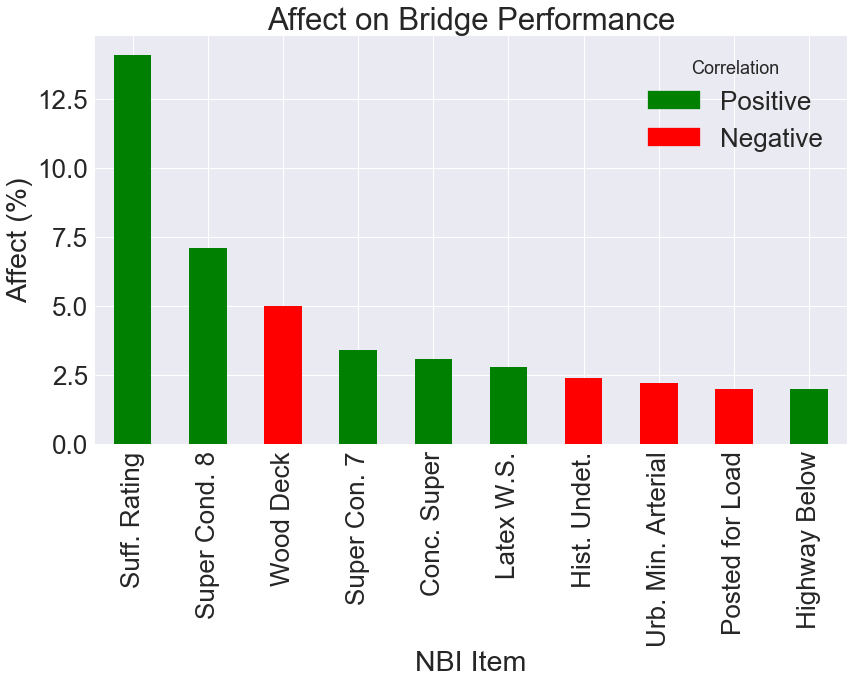

In [37]:
# plot most important features affecting predictions
feat_plot(feat_df, labels)
# plt.savefig('model_output/feat_wgt.png', bbox_inches='tight')